# Order book

Modeling the order book. The order book provides methods for limit and market orders to buy and sell. The order object provides a method to be sent.

In [5]:
import numpy as np
import numpy.random as rng

In [9]:
from dataclasses import dataclass
import abc


@dataclass
class Order(abc.ABC):
    ids = count()

    ob: 'OB'

    @abc.abstractmethod
    def send(self):
        self.id = next(Order.ids)
        # must be called in subclass overrides


@dataclass
class Limit(Order):
    tick: int
    qty:  int
    sell: bool

    def send(self):
        super().send()

        if self.sell:
            self.ob._lsell(self)
        else:
            self.ob._lbuy(self)
        
        return self

    def cancel(self):
        self.cancelled = True
        return self

    @property
    def cancelled(self) -> bool:
        return getattr(self, '_cancelled', False)

    @cancelled.setter
    def cancelled(self, val: bool):
        self._cancelled = val

    @property
    def partial(self) -> int:
        return getattr(self, '_partial', 0)

    @partial.setter
    def partial(self, val: bool):
        self._partial = val

    @property
    def fulfilled(self) -> bool:
        return self.partial >= self.qty

    @property
    def active(self) -> bool:
        return not self.cancelled and not self.fulfilled

    def __hash__(self):
        return getattr(self, 'id', 0)


@dataclass
class Market(Order):
    qty:  int
    sell: bool
    
    def send(self):
        super().send()

        if self.sell:
            self.ob._msell(self)
        else:
            self.ob._mbuy(self)
        
        return self

In [10]:
from collections import defaultdict
from itertools import count
import heapq
from dataclasses import dataclass, field
from typing import List
import math


@dataclass
class OB:
    # heaps of orders ranked by (plus, minus) tick, id
    # once in a while we should filter cancelled orders and heapify à nouveau
    left:  List[Limit]     = field(default_factory=list)
    right: List[Limit]     = field(default_factory=list)
    log:   List[Exception] = field(default_factory=list)

    @staticmethod
    def _get_first_active(heap):  # necessary as cancels are lazy
        if not heap:
            return None

        tick, qty, order = heap[0]
        while not order.active:
            heapq.heappop(heap)

            if not heap:
                return None
            tick, qty, order = heap[0]

        return tick, qty, order

    @property
    def bid(self):
        if not (elem := self._get_first_active(self.left)):
            return -math.inf
        
        ntick, id, order = elem
        return -ntick

    @property
    def ask(self):
        if not (elem := self._get_first_active(self.right)):
            return math.inf
        
        tick, id, order = elem
        return tick

    def _lsell(self, order):
        if order.tick <= self.bid:
            err = ValueError(f'Limit sell is market order')
            self.log.append(err)
            raise err

        heapq.heappush(self.right, (order.tick, order.id, order))
        return order.id

    def _lbuy(self, order):
        if order.tick >= self.ask:
            err = ValueError(f'Limit buy is market order')
            self.log.append(err)
            raise err

        heapq.heappush(self.left, (-order.tick, order.id, order))
        return order.id

    def _market(self, side, qty):
        # assumes enough orders to totally fill
        price = 0
        while qty:
            if not (elem := self._get_first_active(side)):
                err = ValueError(f'Market order consumed all liquidity')
                self.log.append(err)
                raise err

            tick, id, order = elem
            m = min(qty, order.qty)
            qty, order.qty = qty - m, order.qty - m
            
            if m != 0:
                order.partial += m

            price += m * tick

        return price

    def _msell(self, order):
        return self._market(self.left, order.qty)

    def _mbuy(self, order):
        return self._market(self.right, order.qty)
    
    def snapshot(self):
        left, right = defaultdict(int), defaultdict(int)

        for _, _, order in self.left:
            if not order.cancelled:
                left[order.tick] += order.qty
        for _, _, order in self.right:
            if not order.cancelled:
                right[order.tick] += order.qty

        return left, right
    
    def limit(self, *args, **kws):
        return Limit(self, *args, **kws)

    def market(self, *args, **kws):
        return Market(self, *args, **kws)
    
    def impact(self, qty, sell):
        side = self.left if sell else self.right
        while qty >= 0:
            if not (elem := self._get_first_active(side)):
                return math.inf * (-1 if sell else 1)

            tick, id, order
            qty -= min(qty + 1, order.qty)

        return (self.bid if sell else -self.ask) + tick * (-1 if sell else 1)

In [11]:
ob = OB()

ob.limit(0, 100, sell=True).send()
print(ob.snapshot())

ob.market(qty=100, sell=False).send()

print(ob.snapshot())

(defaultdict(<class 'int'>, {}), defaultdict(<class 'int'>, {0: 100}))
(defaultdict(<class 'int'>, {}), defaultdict(<class 'int'>, {0: 0}))


## Bit of mathematics

We assume tick size and order size to be constant and set them to 1.

$$
\begin{align}
    \mu    &= \text{ market order arrival rate} \\
    \alpha &= \text{ limit order arrival rate} \\
    P(d)   &= \text{ probability of sell (buy) limit order being placed at distance $d$ from best bid (ask)} \\
    \delta &= \text{ cancellation rate for limit orders} \\
\end{align}
$$

We assume a log-normal distribution of limit orders away from the best bid / ask. This log-normal distribution is derived from the mean and standard deviation of a normal distribution.

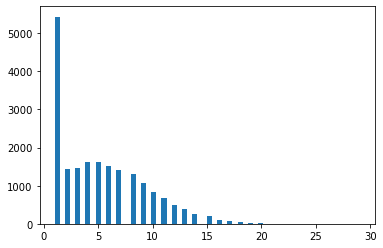

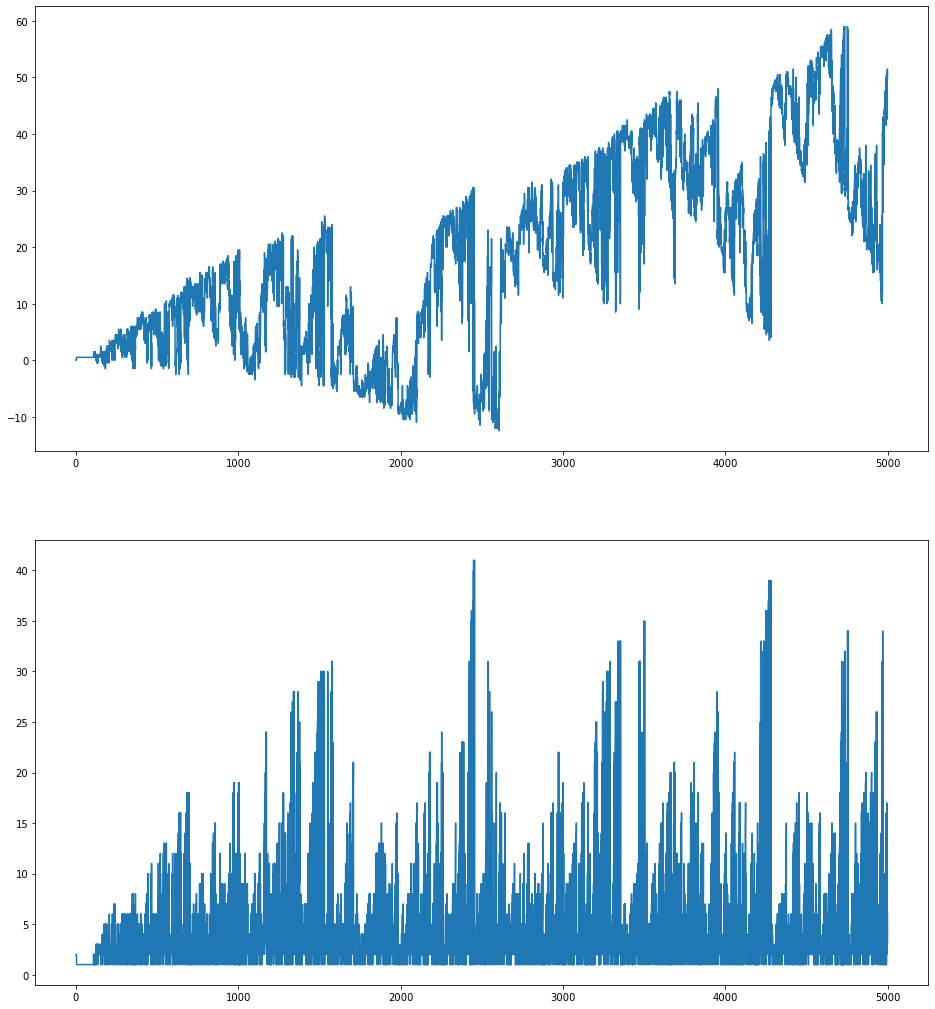

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from itertools import repeat
from random import choice


rng = np.random.default_rng()

def poip(rate, n):
    '''simulate poisson process
    http://www.math.uchicago.edu/~may/VIGRE/VIGRE2010/REUPapers/Mcquighan.pdf
    '''

    u = rng.uniform(size=n)
    y = - np.log(1 - u) / rate
    t = y.cumsum()

    return t

def obm(mu, alpha, delta, mean, sigma, hs, T):
    n, m, l = map(int, (2 * T * mu, 2 * T * alpha, 2 * T * delta))

    dists = 1 + np.trunc(rng.lognormal(mean=mean, sigma=sigma, size=m))
    sizes = np.maximum(1, np.trunc(rng.normal(loc=5, scale=5, size=n)))
    
    plt.hist(sizes[sizes < 60], bins=60)

    markets = zip(hs + poip(mu, n), repeat('market'), rng.choice(2, size=n), sizes)
    limits  = zip(poip(alpha, m),   repeat('limit'),  rng.choice(2, size=m), dists)
    cancels = zip(poip(delta, l),   repeat('cancel'), repeat(None),          repeat(None))
    orders = sorted([*markets, *limits, *cancels])

    ob, spread, limits, snaps = OB(), list(), list(), list()
    limits.append(ob.limit(tick=-1, qty=1, sell=False).send())
    limits.append(ob.limit(tick=1,  qty=1, sell=True).send())
    
    tt = 0
    for t, tp, sell, dist in orders:
        if t > T:
            break

        if   tp == 'market':
            ob.market(qty=1, sell=sell).send()
        elif tp == 'limit':
            tick = ob.bid + dist if sell else ob.ask - dist
            limits.append(ob.limit(qty=1, sell=sell, tick=tick).send())
        elif tp == 'cancel':  # cancel first active order we find
            while limits and not (o := choice(limits)).active:
                limits.remove(o.cancel())

        spread.append((t, ob.bid, ob.ask))

        if np.floor(t) > tt:
            snaps.append(ob.snapshot())
            tt += 1

    return spread, snaps


spread, snaps = obm(mu=2, alpha=2, delta=1.95, mean=1.2, sigma=1, hs=100, T=5000)
t, bid, ask = np.asarray(spread).T

fig, (a, b) = plt.subplots(2, 1, figsize=(16, 18))

_ = a.plot(t, (bid + ask) / 2)
_ = b.plot(t, ask - bid)

# for left, right in snaps:
#     right.update((tick, -qty) for tick, qty in left.items())
#     plt.bar(right.keys(), right.values())
#     plt.show()

array([[1.        , 0.39252773],
       [0.39252773, 1.        ]])

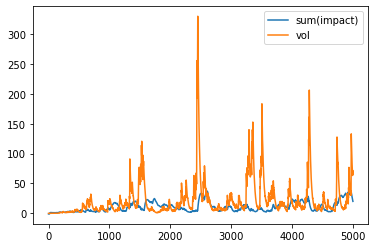

In [20]:
def ema(x, lmbda=0.96):
    ema, m = x[0], []
    for e in x:
        ema = lmbda * ema + (1 - lmbda) * e
        m.append(ema)
    return np.asarray(m)

def vol(price):
    lr = price[1:] - price[:-1]
    lr -= ema(lr)
    return ema(lr ** 2)

def candled(t, y, agg):
    candles = []
    for i in range(0, np.floor(t[-1]).astype(int), agg):
        c = y[(i < t) & (t < (i + agg))]
        candles.append(c[0] if len(c) else (candles[-1] if candles else 0))
    return np.asarray(candles)

def impact(qty, snap):
    left, right = snap
    
    def aux(qty, side, ext):
        while qty >= 0:
            if not side:
                return -ext(math.inf, -math.inf)

            tick = ext(side)
            qty -= min(side.pop(tick), qty + 1)
        
        return tick
    
    sell = max(left) - aux(qty, left.copy(),  max)
    buy  = aux(qty, right.copy(), min) - min(right)

    return buy, sell

impacts = []
for k in range(1, len(snaps)):
    impacts.append(impact(20, snaps[k]))
impacts = np.asarray(impacts)
impacts[np.isinf(impacts)] = -1

# plt.plot(impacts[:, 0], label='buy')
plt.plot(ema(impacts[:, 0]), label='sum(impact)')
plt.plot(vol(candled(t, bid, 1)), label='vol')
plt.legend()

np.corrcoef(impacts.sum(axis=1), vol(candled(t, bid, 1)))